In [1]:
from diffusers import AutoPipelineForInpainting, KandinskyV22InpaintPipeline, KandinskyV22PriorPipeline
from diffusers.utils import load_image
from transformers import CLIPVisionModelWithProjection
import torch
import numpy as np

In [ ]:
# !pip install diffusers transformers accelerate

In [ ]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained('kandinsky-community/kandinsky-2-2-prior', subfolder='image_encoder').to(torch.float16).to('cuda')
pipe_prior = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", image_encoder=image_encoder, torch_dtype=torch.float16)
pipe_prior.to("cuda")

In [ ]:
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnAddedKVProcessor

lora_attn_procs = {}
for name in pipe_prior.prior.attn_processors.keys():
    lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=2048).to('cuda')
    
pipe_prior.prior.set_attn_processor(lora_attn_procs)
pipe_prior.prior.load_state_dict(torch.load('./arbonne-model/kardinsky-prior/checkpoint-300/pytorch_model.bin'), strict=False)
None

In [ ]:
decoder = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16).to("cuda")
decoder.unet.load_attn_procs("./arbonne-model/kardinsky-unet")

In [ ]:
# from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnAddedKVProcessor
# lora_attn_procs = {}
# d = torch.load('./arbonne-model/checkpoint-300/pytorch_model.bin')
# for name in decoder.unet.attn_processors.keys():
#     cross_attention_dim = None if name.endswith("attn1.processor") else decoder.unet.config.cross_attention_dim
#     if name.startswith("mid_block"):
#         hidden_size = decoder.unet.config.block_out_channels[-1]
#     elif name.startswith("up_blocks"):
#         block_id = int(name[len("up_blocks.")])
#         hidden_size = list(reversed(decoder.unet.config.block_out_channels))[block_id]
#     elif name.startswith("down_blocks"):
#         block_id = int(name[len("down_blocks.")])
#         hidden_size = decoder.unet.config.block_out_channels[block_id]
#     lora_attn_procs[name] = LoRAAttnAddedKVProcessor(
#             hidden_size=hidden_size,
#             cross_attention_dim=cross_attention_dim,
#             rank=4,
#     ).to('cuda')

# decoder.unet.set_attn_processor(lora_attn_procs)
# decoder.unet.load_state_dict(d, strict=False)
# None

In [ ]:
prompt = "a photo of body lotion"
negative_prompt = "worst quality, low resolution, text"
image_emb, zero_image_emb = pipe_prior(prompt, return_dict=False)

init_image = load_image("29.jpeg")
mask_image = load_image("29_mask.jpg")

out = decoder(
    image=init_image,
    mask_image=mask_image,
    image_embeds=image_emb,
    negative_image_embeds=zero_image_emb,
    height=512,
    width=512,
    num_inference_steps=75,
    num_images_per_prompt=4,
    guidance_scale=9.5,
).images

In [2]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch
import numpy as np
from PIL import Image, ImageFilter

In [3]:
pipe = AutoPipelineForInpainting.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16).to("cuda")
pipe.enable_attention_slicing()
pipe.enable_model_cpu_offload()

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
mask_blur = 25

prompt = "christmas theme, तdekoracja, fiori, gloeiende lichten, ीखा"

init_image = load_image("29.jpeg")
mask_image = load_image("29_mask.jpg").convert("L")

init_array = np.asarray(init_image)
dummy_ones = np.ones((init_array.shape[0], init_array.shape[1]), dtype=np.float32)
mask = dummy_ones - np.asarray(mask_image)/255.

mask_img = Image.fromarray(np.uint8(mask)*255).convert("L")
mask_img = mask_img.filter(ImageFilter.GaussianBlur(mask_blur))

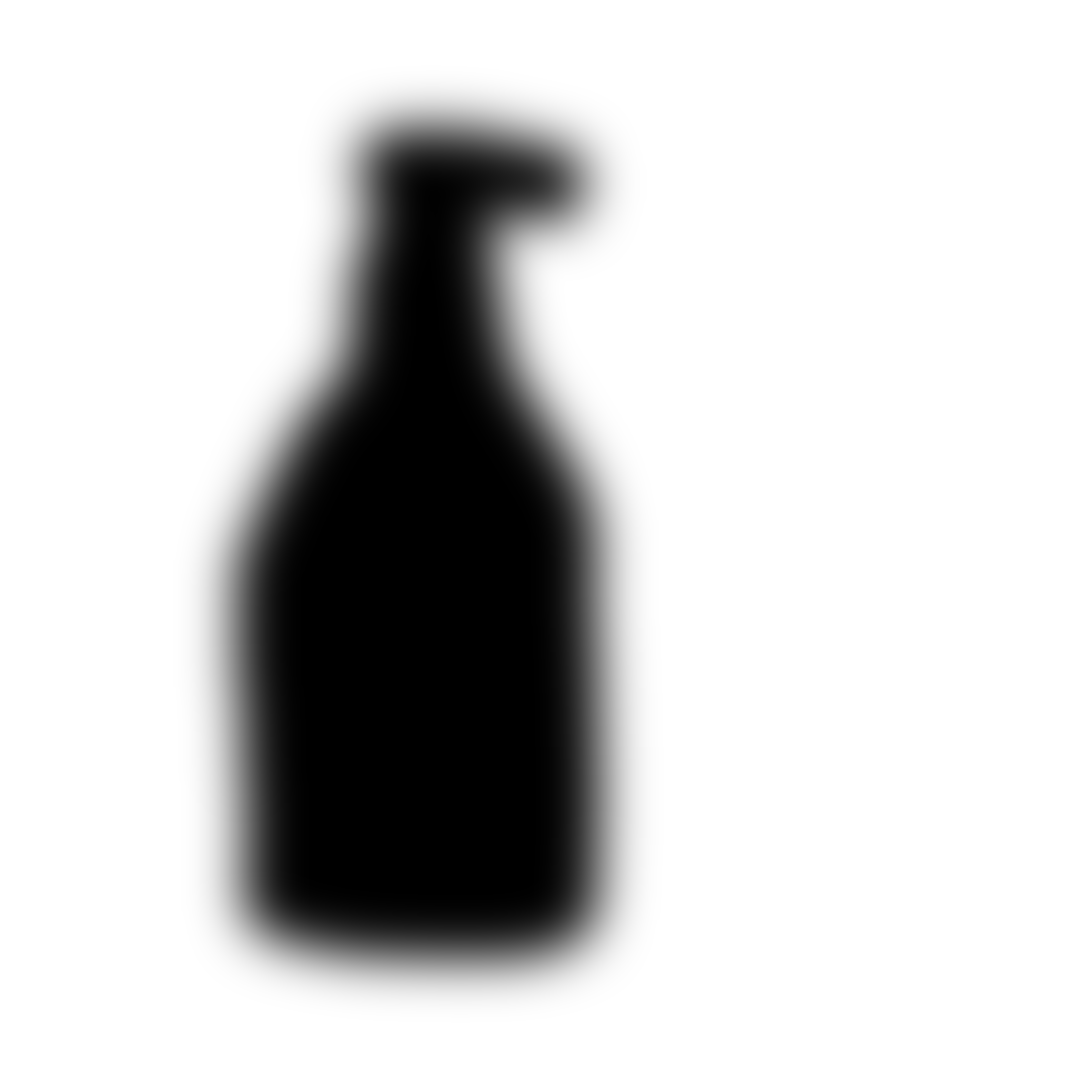

In [5]:
mask_img

In [6]:
seed = 42

out = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask_img,
    height=768,
    width=768,
    num_inference_steps=50,
    guidance_scale = 9.5,
    num_images_per_prompt=2,
    generator = torch.Generator().manual_seed(seed)
).images

  0%|          | 0/25 [00:00<?, ?it/s]

Please note that the expected format of `mask_image` has recently been changed. Before diffusers == 0.19.0, Kandinsky Inpainting pipelines repainted black pixels and preserved black pixels. As of diffusers==0.19.0 this behavior has been inverted. Now white pixels are repainted and black pixels are preserved. This way, Kandinsky's masking behavior is aligned with Stable Diffusion. THIS means that you HAVE to invert the input mask to have the same behavior as before as explained in https://github.com/huggingface/diffusers/pull/4207. This warning will be surpressed after the first inference call and will be removed in diffusers>0.22.0


  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
from diffusers.utils import load_image
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [8]:
out

[<PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>]

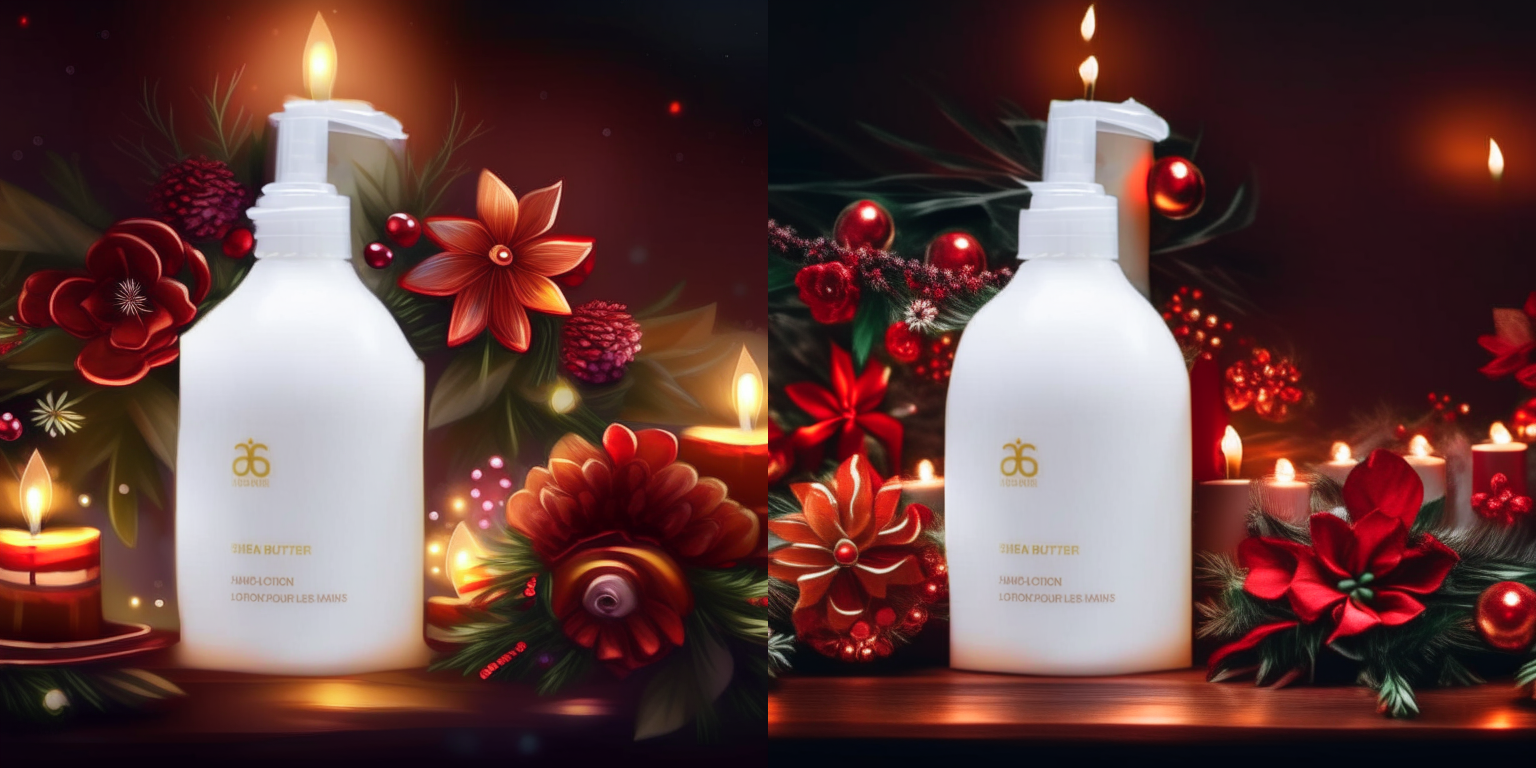

In [9]:
image_grid(out, 1, 2)